In [1]:
!pip install pydub
!pip install librosa
!pip install numba==0.49.0
!pip install llvmlite==0.32.1

  Using cached numba-0.49.0-cp38-cp38-win_amd64.whl (2.1 MB)
  Using cached llvmlite-0.32.1-cp38-cp38-win_amd64.whl (13.6 MB)


ERROR: Cannot uninstall 'llvmlite'. It is a distutils installed project and thus we cannot accurately determine which files belong to it which would lead to only a partial uninstall.


  Attempting uninstall: llvmlite
    Found existing installation: llvmlite 0.36.0
  Using cached llvmlite-0.32.1-cp38-cp38-win_amd64.whl (13.6 MB)
  Attempting uninstall: llvmlite
    Found existing installation: llvmlite 0.36.0


ERROR: Cannot uninstall 'llvmlite'. It is a distutils installed project and thus we cannot accurately determine which files belong to it which would lead to only a partial uninstall.


In [2]:
import numpy as np
import os
import matplotlib.pyplot as plt
import librosa
import random
import shutil
from pydub import AudioSegment
from matplotlib.backends.backend_agg import FigureCanvasAgg
from tensorflow.keras.optimizers import Adam
from keras.layers import Input, Dense, Activation, BatchNormalization, Flatten, Conv2D, MaxPooling2D, Dropout
from keras.models import Model
from keras.initializers import glorot_uniform
from keras.preprocessing.image import ImageDataGenerator
import keras.backend as K

# COLAB = True
COLAB = False


In [3]:
if COLAB:
    from google.colab import drive
    drive.mount('/content/gdrive')
    try:
        os.makedirs('/content/gdrive/MyDrive/Data/spectrograms')
        os.makedirs('/content/gdrive/MyDrive/Data/audio_samples')
    except FileExistsError:
        pass
else:
    try:
        os.makedirs('./spectrograms')
        os.makedirs('./audio_samples')
    except FileExistsError:
        pass

In [4]:
genres = 'blues classical country disco pop hiphop metal reggae rock'
genres = genres.split()

In [5]:
if COLAB:
    for g in genres:
        path1 = os.path.join('/content/gdrive/MyDrive/Data/audio_samples', f'{g}')
        try:
            os.makedirs(path1)
        except FileExistsError:
            pass
        path = os.path.join(
            '/content/gdrive/MyDrive/Data/spectrograms', f'{g}')
        try:
            os.makedirs(path)
        except FileExistsError:
            pass
else:
    for g in genres:
        path1 = os.path.join('./audio_samples', f'{g}')
        try:
            os.makedirs(path1)
        except FileExistsError:
            pass
        path = os.path.join('./spectrograms', f'{g}')
        try:
            os.makedirs(path)
        except FileExistsError:
            pass

In [7]:
i = 0
for g in genres:
    j = 0
    print(f"{g}")
    if COLAB:
        directory = '/content/gdrive/MyDrive/Data/genres_original'
    else:
        directory = './genres_original'
    for filename in os.listdir(os.path.join(directory, f"{g}")):
        song = os.path.join(f'{directory}/{g}', f'{filename}')
        j += 1
        for w in range(0, 10):
            i += 1
            t1 = 3 * w * 1000
            t2 = 3 * (w + 1) * 1000
            newAudio = AudioSegment.from_wav(song)
            new = newAudio[t1:t2]
            if COLAB:
                new.export(
                    f'/content/gdrive/MyDrive/Data/audio_samples/{g}/{g}{j}{w}.wav', format="wav")
            else:
                new.export(
                    f'./audio_samples/{g}/{g}{j}{w}.wav', format="wav")

blues
classical


KeyboardInterrupt: 

blues


KeyboardInterrupt: 

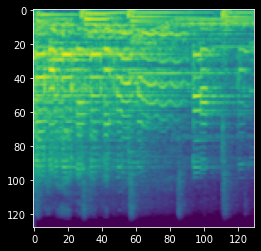

In [8]:
if COLAB:
    directory = '/content/gdrive/MyDrive/Data/audio_samples'
else:
    directory = './audio_samples'
for g in genres:
    j = 0
    print(g)
    for filename in os.listdir(os.path.join(directory, f"{g}")):
        song = os.path.join(f'{directory}/{g}', f'{filename}')
        j = j+1
        y, sr = librosa.load(song, duration=3)
        mels = librosa.feature.melspectrogram(y=y, sr=sr)
        fig = plt.Figure()
        canvas = FigureCanvasAgg(fig)
        p = plt.imshow(librosa.power_to_db(mels, ref=np.max))
        if COLAB:
            plt.savefig(
                f'/content/gdrive/MyDrive/Data/spectrograms/train/{g}/{g}{j}.png')
        else:
            plt.savefig(f'./spectrograms/train/{g}/{g}{j}.png')

In [16]:
# Split data into testing and training
directory = './spectrograms/train/'
print(directory)
if COLAB:
    directory = "/content/gdrive/MyDrive/Data/spectrograms/train/"
for g in genres:
    filenames = os.listdir(os.path.join(directory, f"{g}"))
    print(os.path.join(directory, f"{g}"))
    random.shuffle(filenames)
    test_files = filenames[0:100]
    for f in test_files:
        shutil.move(f"{directory}{g}/{f}", f"{directory[:-6]}test/{g}")

./spectrograms/train/
./spectrograms/train/blues
./spectrograms/train/classical
./spectrograms/train/country
./spectrograms/train/disco
./spectrograms/train/pop
./spectrograms/train/hiphop
./spectrograms/train/metal
./spectrograms/train/reggae
./spectrograms/train/rock


In [17]:
train_directory = directory
train_data_generator = ImageDataGenerator(rescale=1./255)
train_generator = train_data_generator.flow_from_directory(train_directory, target_size=(
    288, 432), color_mode="rgba", class_mode='categorical', batch_size=128)

validation_directory = f"{directory[:-6]}test/"
validation_data_generator = ImageDataGenerator(rescale=1./255)
validation_generator = validation_data_generator.flow_from_directory(validation_directory, target_size=(
    288, 432), color_mode='rgba', class_mode='categorical', batch_size=128)

Found 8102 images belonging to 9 classes.
Found 900 images belonging to 9 classes.


In [18]:
def cnn(input_shape=(288, 432, 4), classes=9):
    def step(dim, X):
        X = Conv2D(dim, kernel_size=(3, 3), strides=(1, 1))(X)
        X = BatchNormalization(axis=3)(X)
        X = Activation('relu')(X)
        return MaxPooling2D((2, 2))(X)
    X_input = Input(input_shape)
    X = X_input
    layer_dims = [8, 16, 32, 64, 128, 256]
    for dim in layer_dims:
        X = step(dim, X)

    X = Flatten()(X)
    X = Dropout(rate=0.3)
    X = Dense(classes, activation='softmax',
              name=f'fc{classes}',  kernel_initializer=glorot_uniform(seed=9))(X)
    model = Model(inputs=X_input, outputs=X, name='cnn')
    return model

def f1_score(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2 * (precision * recall) / (precision + recall + K.epsilon())
    return f1_val

In [19]:
model = cnn(input_shape=(288, 432, 4), classes=9)
opt = Adam(learning_rate=0.00005)
model.compile(optimizer=opt, loss='categorical_crossentropy',
              metrics=['accuracy', f1_score])
model.summary()

Model: "cnn"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 288, 432, 4)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 286, 430, 8)       296       
_________________________________________________________________
batch_normalization (BatchNo (None, 286, 430, 8)       32        
_________________________________________________________________
activation (Activation)      (None, 286, 430, 8)       0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 143, 215, 8)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 141, 213, 16)      1168      
_________________________________________________________________
batch_normalization_1 (Batch (None, 141, 213, 16)      64      

In [22]:
model.fit(train_generator, epochs=40, validation_data=validation_generator)

Epoch 1/40
64/64 [==============================] - 367s 6s/step - loss: 1.7289 - accuracy: 0.3679 - f1_score: 0.1924 - val_loss: 2.2369 - val_accuracy: 0.1111 - val_f1_score: 0.0000e+00
Epoch 2/40
64/64 [==============================] - 357s 6s/step - loss: 1.4400 - accuracy: 0.4832 - f1_score: 0.3208 - val_loss: 2.3125 - val_accuracy: 0.1111 - val_f1_score: 0.0000e+00
Epoch 3/40
64/64 [==============================] - 364s 6s/step - loss: 1.2658 - accuracy: 0.5437 - f1_score: 0.4157 - val_loss: 2.4095 - val_accuracy: 0.1211 - val_f1_score: 0.0000e+00
Epoch 4/40
64/64 [==============================] - 363s 6s/step - loss: 1.1316 - accuracy: 0.5989 - f1_score: 0.4770 - val_loss: 2.4434 - val_accuracy: 0.2567 - val_f1_score: 0.1279
Epoch 5/40
64/64 [==============================] - 357s 6s/step - loss: 1.0455 - accuracy: 0.6311 - f1_score: 0.5446 - val_loss: 2.4389 - val_accuracy: 0.2733 - val_f1_score: 0.2725
Epoch 6/40
64/64 [==============================] - 370s 6s/step - loss: 

In [ ]:
model.save('CNNModelWeights_new', save_format='h5')

In [ ]:
model.evaluate()